In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os

plot_folder = "../plots/0_controls/"

# create it if it does not exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

In [37]:
# read the stability measured across cell lines in the library 1
# these data have already been normalized to make them more comparable
data_dir_input = "../input_data/measurements_lib1/non_miRNA_UTR_sequences"

# get the name of all files in "reference" folder
library_df = pd.read_csv(os.path.join(data_dir_input, "lib1_other_seqs.csv"), index_col=0)

In [39]:
# non seq columns
non_seq_columns = [column for column in library_df.columns if "seq" not in column]
library_df["mean"] = library_df[non_seq_columns].mean(axis=1)
library_df["variance"] = library_df[non_seq_columns].var(axis=1)
library_df.sort_values(by="variance", ascending=True, inplace=True)

## Pick context sequences

In [41]:
# Get the top 120 sequences by variance for further processing
chosen_sequences = library_df.head(120)

In [42]:
# paste sequences together to get context sequences of sufficient length
appended_sequences = []
appended_names = []
# paste the sequences together
for i in range(int(len(chosen_sequences)/2)):
    appended_sequences.append(chosen_sequences.iloc[[i,2*i], :]["seq"].str.cat(sep=""))
    appended_names.append(chosen_sequences.iloc[[i,2*i], :].index.str.cat(sep="_"))

In [43]:
# create the dataframe and shorten the appended sequences to the desired length
desired_length = 200 - 18 - 18
df_appended_sequences = pd.DataFrame(appended_sequences,
    index=[f"0_lib2_controls_{i+2}" for i in range(len(appended_sequences))], columns=["seq"])

df_appended_sequences["source_seq"] = appended_names
df_appended_sequences["seq"] = df_appended_sequences["seq"].str[0:desired_length]

In [44]:
# add the manually chosen main context
ctx_lib2_1_name = "0_lib2_controls_1"
ctx_lib2_1_seq = "AAAGAGCAGAAGCAGCAGCATCTCTGTACATTTTGGAGCCAAGGGTTCAGAGACTCAGGGCCCCAGCACTTAAGCAGTGGACACCAGGAGTCCCTGGTAATCAGT" + \
                "ACTGTGTACAGAATTCTGCTACCTCACTACAAGCAGAAGGAAACATTGAACTCAGAGCC"

ctx_lib2_source_seq = "main_context"

df_appended_sequences.loc[ctx_lib2_1_name, :] = [ctx_lib2_1_seq, ctx_lib2_source_seq]

# move the manually chosen context to the top of the dataframe
df_appended_sequences = df_appended_sequences.reindex([ctx_lib2_1_name] + [i for i in df_appended_sequences.index if i != ctx_lib2_1_name])

In [45]:
# get rid of ATGs in the first 40 sequences
# this makes the library potentially compatible with 5' UTR measurements
first_forty = df_appended_sequences.head(40).index
df_appended_sequences.loc[first_forty, "seq"] = df_appended_sequences.loc[first_forty, "seq"].str.replace("ATG", "AAG")

## Remove polyA sequences and potential restriction sites
### (ended up using Gibson cloning, so this isn't really necessary)

In [11]:
# check for unwanted motifs
# BsaI sites
restriction_sites = ["GAGACC", "GGTCTC"]
# Most of these aren't strong polyA signals, but they are close enough that they could end up being problematic
polyA_signals = ["AATAAA", "ATTAAA", "AGTAAA", "TATAAA", "ACTAAA"]
filter_motifs = restriction_sites + polyA_signals

In [12]:
# Add the new fixed sequences before checking for unwanted motifs
left_handle = "ACGACGCTCTTCCGATCT"
right_handle = "CTCTGGATTTGCAACCGA"

df_appended_sequences["ext_seq"] = left_handle + df_appended_sequences["seq"] + right_handle

In [13]:
# How many sequences contain the filter motifs?
print(df_appended_sequences["ext_seq"].str.contains('|'.join(filter_motifs)).sum())
df_appended_sequences["unwanted_motif"] = df_appended_sequences["ext_seq"].str.contains('|'.join(filter_motifs))

# Drop the sequences that contain unwanted motifs
df_appended_sequences = df_appended_sequences[df_appended_sequences["unwanted_motif"] == False]

# Remove ext_seq and unwanted_motif columns
df_appended_sequences.drop(["ext_seq", "unwanted_motif"], axis=1, inplace=True)

8


In [14]:
# Rename the index to be consecutive
df_appended_sequences.index = [f"0_lib2_controls_{i+1}" for i in range(len(df_appended_sequences))]

In [15]:
len(df_appended_sequences)

53

In [16]:
# Save the result to a file
df_appended_sequences.to_csv("../designs/0_lib2_controls.csv")

# Investigate the sequence diversity

In [17]:
# add the GC content
df_appended_sequences["gc_content"] = [(seq.count("G") + seq.count("C"))/len(seq) for seq in df_appended_sequences["seq"]]

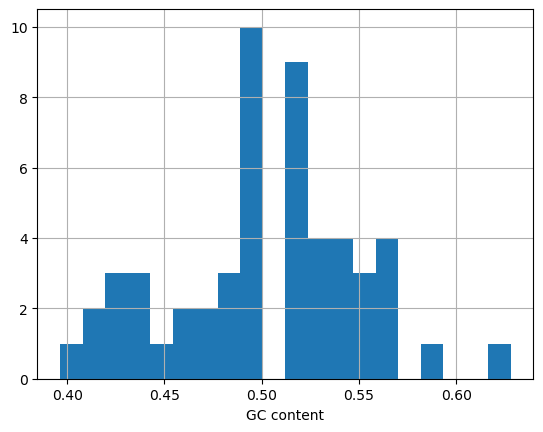

In [18]:
# plot a hist
fig = df_appended_sequences["gc_content"].hist(bins=20)
plt.xlabel("GC content")
plt.savefig(plot_folder + "gc_content_hist.png", dpi=300)

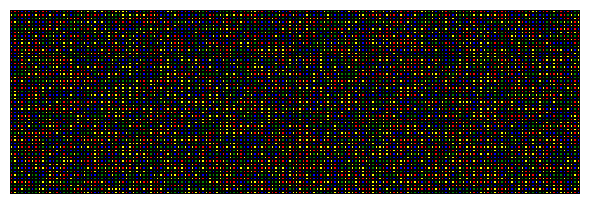

In [19]:
df = df_appended_sequences.copy()

# DNA to numerical mapping
dna_to_num = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3
}

def sequence_to_nums(sequence):
    return [dna_to_num[base] for base in sequence]

# Convert sequences to numerical matrices
df['num_map'] = df['seq'].apply(sequence_to_nums)

# Extracting all numerical maps
num_maps = np.array(df['num_map'].tolist())

# Create a custom colormap
cmap = mcolors.ListedColormap(['red', 'green', 'blue', 'yellow'])

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(6, 2.5))

sns.heatmap(
    data=num_maps,
    ax=ax,
    cmap=cmap,
    square=True,
    linewidths=0.1,
    linecolor='black',
    cbar=False
)

# Removing x and y ticks for cleaner visualization
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig(plot_folder + "sequence_heatmap.png", dpi=300)